# Computer vision - Laboratory

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics are:

1)	Segmentation of video shots with static scenes.

2) Background substraction.

3)	Segmentation of images.

In order to successfuly complete this practicum it is necessary to understand the following theory concepts: background substraction, K-means clustering, etc.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.

## 3.1 Background substraction methods


Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, remove all the "artifacts" considered as foreground related to movement extracting the background images.

Note: One of the applications of these methods is the button "remove tourists" implemented in most commercial photo cameras. For instance, Adobe uses the "Monument Mode", which automatically deletes the people going by the cameras.

Read and visualize the sequence of images "images/Barcelona-sequence"
Hint: In order to read a  collection of images, we wil use the function animation.FuncAnimation [https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.animation.FuncAnimation.html].

Observe in the following example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

In [20]:
import numpy as np
from skimage import *
from matplotlib import pyplot as plt
from scipy.ndimage import convolve
from skimage.color import rgb2gray, rgba2rgb
from skimage.filters import median
from skimage.exposure import histogram
from skimage.segmentation import felzenszwalb, mark_boundaries, slic
import matplotlib.animation as animation

ic = io.ImageCollection('images/Barcelona-sequence/*.png')

<IPython.core.display.Javascript object>


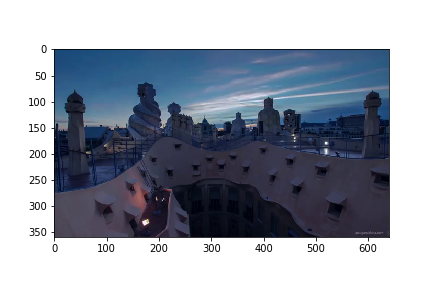

In [22]:
%matplotlib nbagg 
# Changing the pluggin is necessary always when visualizing a video!

i = 0 #Inicializing the video display
fig = plt.figure()  # Create figure
im = plt.imshow(ic[i], animated=True) # Visualize the first image

def updatefig1(i):   # Updating the frame visualization
    im.set_array(ic[i*5]) # Changing the content of the canvas
    return im, # to return a tuple!

ani = animation.FuncAnimation(fig, updatefig1, interval=5, blit=False, frames=50, repeat= False)

a) Find where a shot (scene) finishes and the following starts (boundaries). Each of the scenes in a video is usually called 'shot'. Which measure can be used in order to visually distinguish the shots in a plot? Explain your solution.

Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">

**Hint:** take the following example of video and temporal plot visualization as a template. The plot must be replaced by a frame by frame measure to be defined by you, being applicable to distinguish the shots.

- If you need to convert the image to float, the command is: img_as_float()
- If you need the histogram, it is in skimage.exposure

<IPython.core.display.Javascript object>


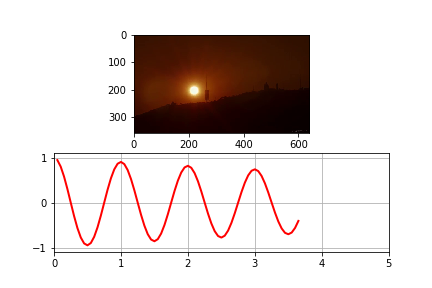

In [24]:
# Example
# Sinusoidal plot points generation
def data_gen():
    t = data_gen.t
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.05
        y = np.cos(2*np.pi*t) * np.exp(-t/10.)
        # adapted the data generator to yield both sin and cos
        yield t, y

data_gen.t = 0

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(-1.1, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=10, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


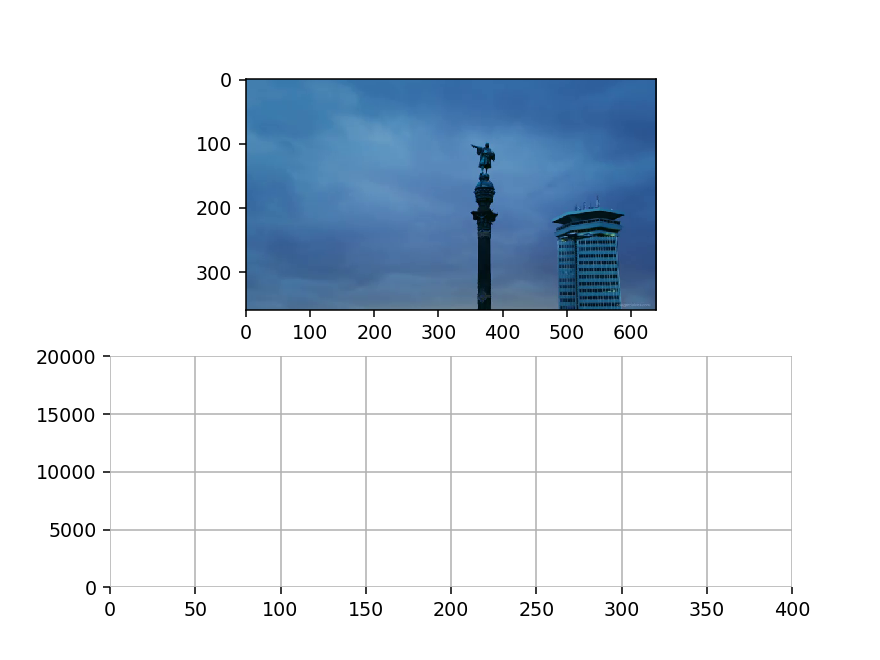

In [4]:
# Will contain start and end frames of each shot. Initialized with first and last frame from the collection.
clips = [ic[0], ic[-1]]

def image_difference(i1, i2):
    
    # Compute histograms of both images and it's difference.
    hist1, _ = histogram(img_as_float(i1), nbins=16)
    hist2, _ = histogram(img_as_float(i2), nbins=16)
    diff = np.mean(abs(hist1 - hist2))
    
    # A difference value over 15000 means change of shot.
    if diff > 15000:
        # Both frames are added before the last one.
        clips.insert(len(clips) - 1, i1)
        clips.insert(len(clips) - 1, i2)
    
    return diff

%matplotlib nbagg

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 20000)
ax2.set_xlim(0, 25)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t = data
    xdata.append(t) # time = x axis
    if len(xdata):
        y = image_difference(ic[len(xdata) - 1], ic[len(xdata)])
    else:
        y = 0
    ydata.append(y) # y axis

    # Plot image on top row
    ax1.imshow(ic[len(xdata)])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line

ani = animation.FuncAnimation(fig, run, blit=False, interval=5, repeat=False, frames=500)
plt.show()

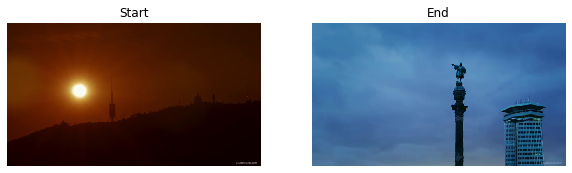

In [28]:
clips = [ic[0], ic[-1]]

%matplotlib inline
def plot_two_images(i1, t1, i2, t2):
    
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(10, 10)
    
    axs[0].axis('off')
    axs[0].imshow(i1)
    axs[0].set_title(t1)
    axs[1].axis('off')
    axs[1].imshow(i2)
    axs[1].set_title(t2)
    plt.show()

for i in range(0, len(clips), 2):
    plot_two_images(clips[i], "Start", clips[i+1], "End")

**Answer:** In order to properly differentiate each shot, the measure we've used is the mean of the difference of histograms. Difference values over 15000 are understood as a start/ending frame between two shots.

## 3.2 Background substraction

Apply the background substraction algorithm (check theory material).

Visualize, for each shot of the video:
    1) images belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

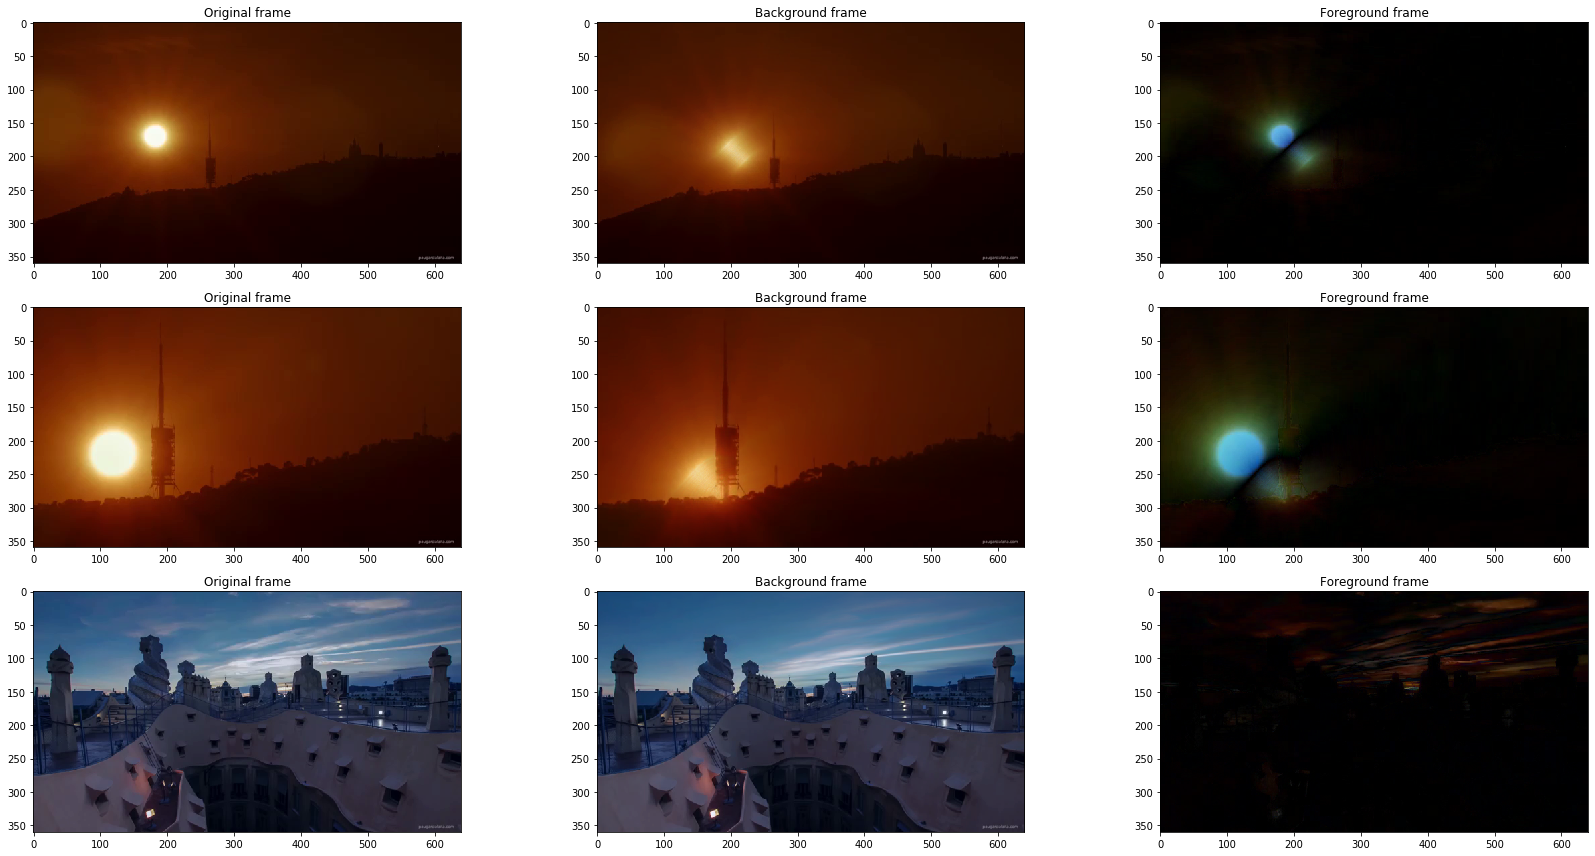

In [29]:
# First of all, we see that we have a sequence with 3 shots. Meaning that there are 3 diferents "images" at which we have to
# apply background substraction.

# We define the frames of the three shots in the sequence.
Shot1_frame = np.arange(0,102+1)
Shot2_frame = np.arange(103,193+1)
Shot3_frame = np.arange(195,287+1)

# We create the matrices for the background of each shot. We initialize them with 0 values.
Shot1_background = np.zeros([360,640,3])
Shot2_background = np.zeros([360,640,3])
Shot3_background = np.zeros([360,640,3])

# Create variables to store information of the following loops.
# First, we define a variable image for each shot.
# Then, we need to creat a variable for each channel within an image.
Shot1_image = []
Shot2_image = []
Shot3_image = []

Shot1_image_R = []
Shot1_image_G = []
Shot1_image_B = []

Shot2_image_R = []
Shot2_image_G = []
Shot2_image_B = []

Shot3_image_R = []
Shot3_image_G = []
Shot3_image_B = []

# In these loops we add to the information of the frames into the variables that we have just created.
for i in Shot1_frame:
    Shot1_image.append(img_as_float(ic[ i ]))
    Shot1_image_R.append(img_as_float(ic[ i ][...,0]))
    Shot1_image_G.append(img_as_float(ic[ i ][...,1]))
    Shot1_image_B.append(img_as_float(ic[ i ][...,2]))   

for i in Shot2_frame:
    Shot2_image.append(img_as_float(ic[ i ]))
    Shot2_image_R.append(img_as_float(ic[ i ][...,0]))
    Shot2_image_G.append(img_as_float(ic[ i ][...,1]))
    Shot2_image_B.append(img_as_float(ic[ i ][...,2])) 

for i in Shot3_frame:
    Shot3_image.append(img_as_float(ic[ i ]))
    Shot3_image_R.append(img_as_float(ic[ i ][...,0]))
    Shot3_image_G.append(img_as_float(ic[ i ][...,1]))
    Shot3_image_B.append(img_as_float(ic[ i ][...,2])) 

# Now, we get the background by applying a median filter as mentioned in the slides. As we can see we have to apply it.
# independently to each channel.
Shot1_background[...,0] = np.median(Shot1_image_R, axis=0)
Shot1_background[...,1] = np.median(Shot1_image_G, axis=0)
Shot1_background[...,2] = np.median(Shot1_image_B, axis=0)

Shot2_background[...,0] = np.median(Shot2_image_R, axis=0)
Shot2_background[...,1] = np.median(Shot2_image_G, axis=0)
Shot2_background[...,2] = np.median(Shot2_image_B, axis=0)

Shot3_background[...,0] = np.median(Shot3_image_R, axis=0)
Shot3_background[...,1] = np.median(Shot3_image_G, axis=0)
Shot3_background[...,2] = np.median(Shot3_image_B, axis=0)

# We initialize variables for the foreground of each shot. und substraction
Shot1_foreground = []
Shot2_foreground = []
Shot3_foreground = []

# We compute the foreground substracting the background from the original image. "abs" just makes sure we get de absolute value.

for i in Shot1_image:
    Shot1_foreground.append(abs(i - Shot1_background))
    
for i in Shot2_image:
    Shot2_foreground.append(abs(i - Shot2_background))
    
for i in Shot3_image:
    Shot3_foreground.append(abs(i - Shot3_background))


# Showing the results. The first row represents the first shot, the second one the second shot and the third one the last shot.
fig,((ax0,ax1,ax2),(ax3,ax4,ax5),(ax6,ax7,ax8)) = plt.subplots(ncols=3,nrows=3,figsize=(24,12))

# First shot.
ax0.imshow(Shot1_image[0])
ax0.set_title("Original frame")

ax1.imshow(Shot1_background)
ax1.set_title("Background frame")

ax2.imshow(Shot1_foreground[0])
ax2.set_title("Foreground frame")

# Second shot.
ax3.imshow(Shot2_image[0])
ax3.set_title("Original frame")

ax4.imshow(Shot2_background)
ax4.set_title("Background frame")

ax5.imshow(Shot2_foreground[0])
ax5.set_title("Foreground frame")

# Third shot.
ax6.imshow(Shot3_image[0])
ax6.set_title("Original frame")

ax7.imshow(Shot3_background)
ax7.set_title("Background frame")

ax8.imshow(Shot3_foreground[0])
ax8.set_title("Foreground frame")

plt.tight_layout()
plt.show()

Comment your implementation including details. What happens if the shots are not correctly extracted? What happens if you find too many shots in the video? What do the static background images represent? In which situations does the algorithm work and in which it does not? What happens if you substract the background image from the original one?

Do you see any additional application for this algorithm?

**[OPTIONAL]**
Apply the algorithm to some other static video that you found.

## 3.3 Clustering methods on the RGB-XY space

a) Read any image from the folder 'images' and segment it using Felzenszwalbs's method. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? Which are the optimal values? Comment what algorithm is the method based in up to 3 lines most.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline)
- Add title to the figures to explain what is displayed.

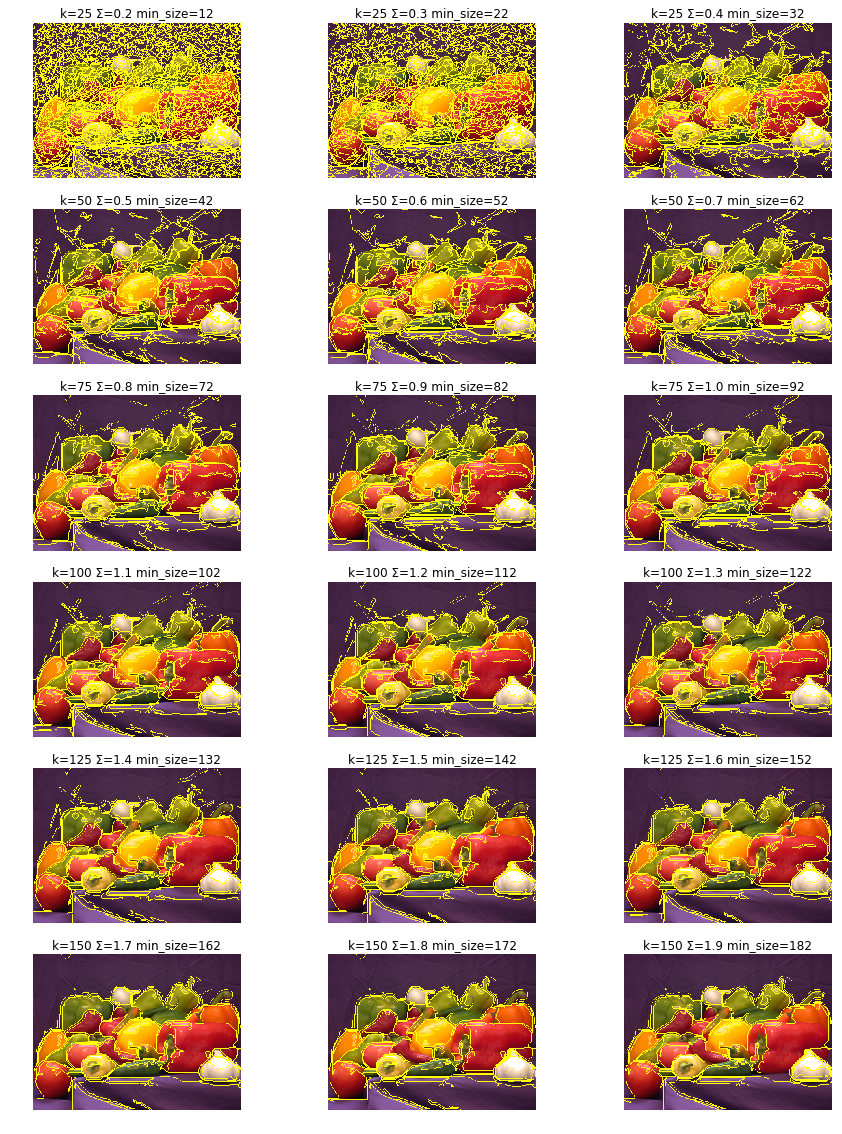

In [6]:
def felzenszwalb_experiment(im, scale, sigma, min_size, a):
    
    # Compute Felzenszwalb segments.
    b = felzenszwalb(im, scale=scale, sigma=sigma, min_size=min_size)
    a.axis('off')
    # Mark segments in image.
    a.imshow(mark_boundaries(im, b))
    a.set_title("k={} Σ={} min_size={}".format(scale, sigma, min_size))
    return a

%matplotlib inline
asd = io.imread("images/peppers.png")

fig, axs = plt.subplots(6, 3)
fig.set_size_inches(15, 20)
k, sigma, min_size = 25, 0.1, 2
for row in range(6):
    for col in range(3):
        sigma += 0.1
        min_size += 10
        axs[row][col] = felzenszwalb_experiment(asd, k, round(sigma, 3), min_size, axs[row][col])
    k += 25
    
plt.show()

**Felzenszwalb parameters:** ***Scale*** parameter changes the clusters sizes, ***sigma*** changes the width of the Gaussian kernel used in preprocessing in order to smooth the image and ***min_size*** sets the minimum size for each component. From the experiments performed, it could be said that scale=150, sigma=1.8 and min_size=172 would give us a pretty good segmentation.

**Felzenszwalb algorithm:** The algorithm is based on a agglomerative clustering algorithm, which merges two close clusters (similar) until some criteria stops it.

b) Segment the previous image using SLIC algorithm. Test different parameters in order to obtain a good image segmentation. How does each parameter behave? In your opinion, which are the optimal values? Comment what algorithm is the method based in up to 3 lines.

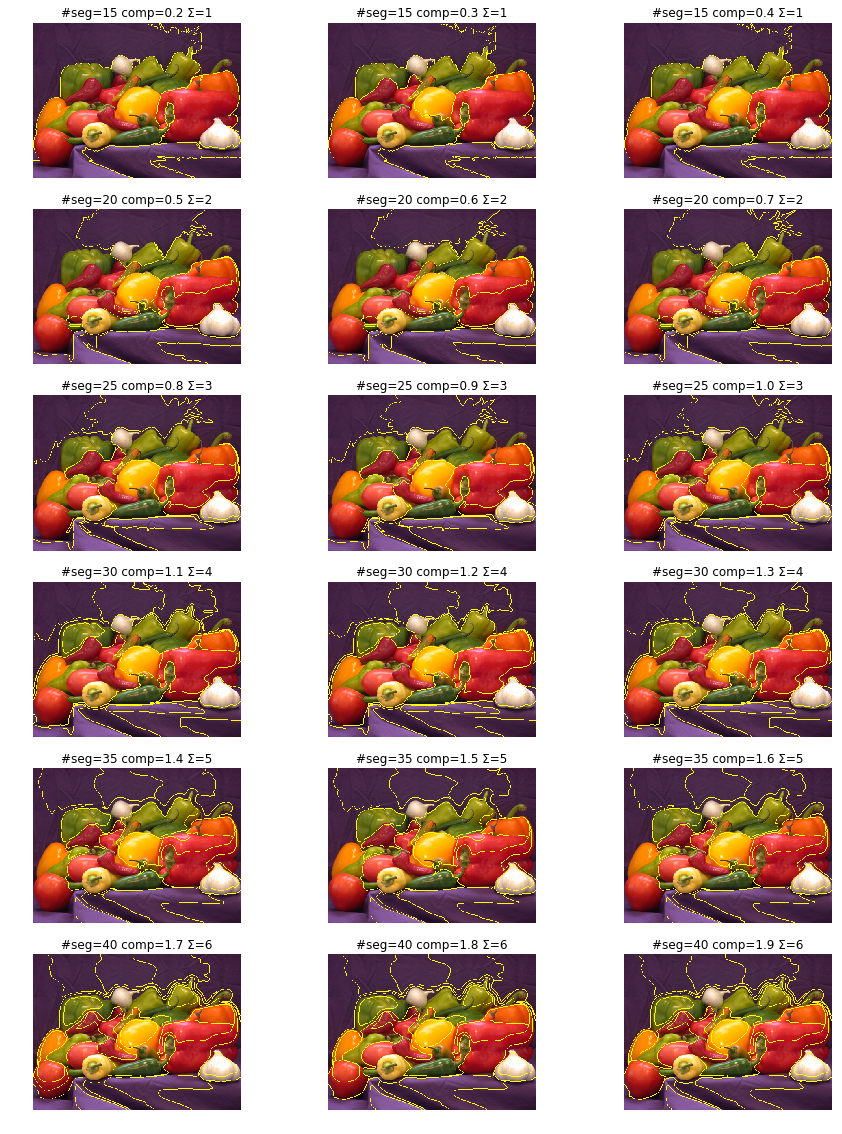

In [7]:
def slic_experiment(im, nseg, comp, sigma, a):
    
    # Compute Slic segments.
    b = slic(im, n_segments=nseg, compactness=comp, sigma=sigma)
    a.axis('off')
    # Mark segments in image.
    a.imshow(mark_boundaries(im, b))
    a.set_title("#seg={} comp={} Σ={}".format(nseg, comp, sigma))
    return a

%matplotlib inline
asd = io.imread("images/peppers.png")

fig, axs = plt.subplots(6, 3)
fig.set_size_inches(15, 20)
seg, comp, sigma = 15, 0.2, 1
for row in range(6):
    for col in range(3):
        axs[row][col] = slic_experiment(asd, seg, round(comp, 3), round(sigma, 3), axs[row][col])
        comp += 0.1
    sigma += 1
    seg += 5
    
plt.show()

**Slic parameters:** ***n_segments*** is an optional parameter that establishes the approximate maximum number of labels in the segmented image, ***compactness*** determines color and space proximity and ***sigma*** changes the width of the Gaussian kernel used in preprocessing in order to smooth the image. From the experiments performed, the best segmentation has been optained with the following parameters: n_segments=40, compactness=1.9, sigma=6.

**Slic algorithm:** The algorithm is based on a K-means clustering algorithm, that re-assigns points to the nearest cluster iteratively.

c) Plot the original image and the results of both algorithms in a 1x3 subplot. Calculate also the number of segments obtained on the image by each of the algorithms. Comment the differences between each method as well as their advantages and disadvantages.

Felzenszwalb #segments: 72
Slic #segments: 26


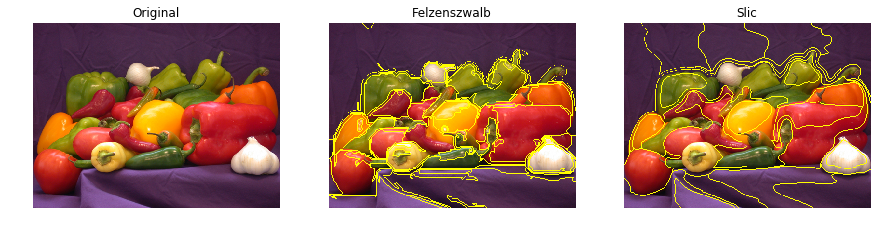

In [8]:
asd = io.imread("images/peppers.png")
f = felzenszwalb(asd, scale=150, sigma=1.8, min_size=172)
s = slic(asd, n_segments=40, compactness=1.9, sigma=6)

# Number of segments is obtained by counting the unique values in the mask obtained with the segmentation
# algorithms.
print("Felzenszwalb #segments: {}\nSlic #segments: {}".format(len(np.unique(f)), len(np.unique(s))))

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 10)
titles, images = ["Original", "Felzenszwalb", "Slic"], [asd, mark_boundaries(asd, f), mark_boundaries(asd, s)]
for i in range(len(axs)):
    axs[i].axis('off')
    axs[i].imshow(images[i])
    axs[i].set_title(titles[i])
plt.show()

**Comparison Felzenszwalb & Slic:** Both are simple algorithms for image segmentation, however Slic converges to a local minimum of the error function whereas Felzenszwalb does not. Another difference is that Slic has a maximum number of iterations until it stops and  Felzenszwalb needs and extra measure for it to stop clusetering. Performance-wise, Slic is quite memory intensive.